In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import tensorflow as tf

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping

%matplotlib inline

## Image Augmentation

In [3]:
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
 
 
data_datagen = ImageDataGenerator(rescale=1./255)
 
data_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15, 
                                   shear_range=0.5,  
                                   # width_shift_range=0.1,
                                   # height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest') 

'''
rotation_range: 이미지 회전 범위 (degrees)
width_shift, height_shift: 그림을 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
rescale: 원본 영상은 0-255의 RGB 계수로 구성되는데, 이 같은 입력값은 모델을 효과적으로 학습시키기에 너무 높습니다 (통상적인 learning rate를 사용할 경우). 그래서 이를 1/255로 스케일링하여 0-1 범위로 변환시켜줍니다. 이는 다른 전처리 과정에 앞서 가장 먼저 적용됩니다.
shear_range: 임의 전단 변환 (shearing transformation) 범위
zoom_range: 임의 확대/축소 범위
horizontal_flip: True로 설정할 경우, 50% 확률로 이미지를 수평으로 뒤집습니다. 원본 이미지에 수평 비대칭성이 없을 때 효과적입니다. 즉, 뒤집어도 자연스러울 때 사용하면 좋습니다.
fill_mode 이미지를 회전, 이동하거나 축소할 때 생기는 공간을 채우는 방식
 '''
 
pre_dir = '/content/gdrive/MyDrive/dataa/train'
folders = os.listdir(pre_dir) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
folders.sort() 

filename_in_dir = [] 

for i in range(len(folders)):
  path = pre_dir + "/" + folders[i] 
  os.chdir(path) # 해당 폴더로 이동
  files = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
  for j in range(len(files)):
    pre_image = path + '/' + files[j]
    img = load_img(pre_image) 
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    k = 0
    for batch in data_datagen.flow(x,save_to_dir='/content/gdrive/MyDrive/dataa/train/'+folders[i], save_prefix='augmentation', save_format='jpg'):
        k += 1
        if k > 10: # 최대 6장씩 부풀리기
            break


#### 데이터 경로 지정

In [29]:
#train_dir = '/content/drive/MyDrive/클라우드플랫폼/data/train'
#validation_dir = '/content/drive/MyDrive/클라우드플랫폼/data/validation'
#test_dir = '/content/drive/MyDrive/클라우드플랫폼/data/test'

train_dir = '/content/gdrive/MyDrive/dataa/train'
validation_dir = '/content/gdrive/MyDrive/dataa/validation'
test_dir = '/content/gdrive/MyDrive/dataa/test'

#### 예시 이미지 확인

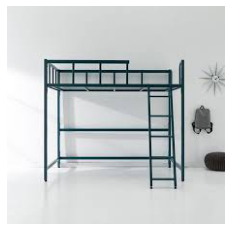

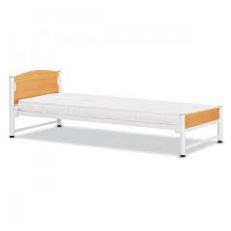

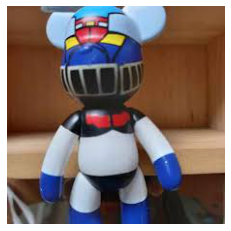

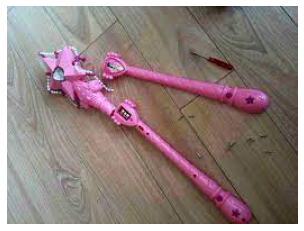

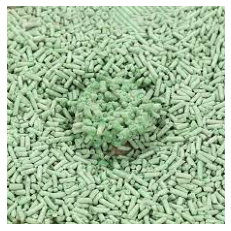

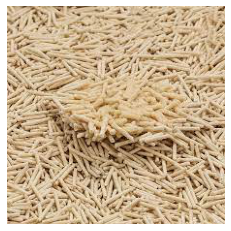

In [12]:
#flag_dir = os.path.join('/content/drive/MyDrive/클라우드플랫폼/data/train/flag')
#pad_dir = os.path.join('/content/drive/MyDrive/클라우드플랫폼/data/train/pad')
#umbrella_dir = os.path.join('/content/drive/MyDrive/클라우드플랫폼/data/train/umbrella')

flag_dir = os.path.join('/content/gdrive/MyDrive/dataa/train/bed')
pad_dir = os.path.join('/content/gdrive/MyDrive/dataa/train/toy')
umbrella_dir = os.path.join('/content/gdrive/MyDrive/dataa/train/sand')
flag_files = os.listdir(flag_dir)
pad_files = os.listdir(pad_dir)
umbrella_files = os.listdir(umbrella_dir)

pic_index = 2

next_flag = [os.path.join(flag_dir, fname) for fname in flag_files[pic_index-2:pic_index]]
next_pad = [os.path.join(pad_dir, fname) for fname in pad_files[pic_index-2:pic_index]]
next_umbrella = [os.path.join(umbrella_dir, fname) for fname in umbrella_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_flag + next_pad + next_umbrella):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

## train, validation 이미지 데이터 조정

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=50, # step 1회 당 사용하는 데이터 수
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')

Found 27778 images belonging to 30 classes.
Found 598 images belonging to 30 classes.


In [19]:
# 이미지 데이터 사이즈 / 레이블 크기

for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (50, 150, 150, 3)
배치 레이블 크기: (50, 30)


## CNN 모델 생성

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import models

np.random.seed(3)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(30, activation='softmax')) # 5가지로 다중분류

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)       

## 모델 컴파일

In [23]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',  # rmsprop
              metrics=['acc'])

## 모델 학습

In [25]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_generator,
                   validation_data=validation_generator,
                   steps_per_epoch=10, # 가중치 1회 업데이트 당 학습횟수
                   epochs=10             
                   #validation_steps=1,
                  #callbacks=[early_stopping_callback]
                    )   

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 3.3996 - acc: 0.0480

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/10 [==============================] - 113s 12s/step - loss: 3.3996 - acc: 0.0480 - val_loss: 3.3980 - val_acc: 0.0334
Epoch 2/10
10/10 [==============================] - 31s 3s/step - loss: 3.4239 - acc: 0.0600 - val_loss: 3.3884 - val_acc: 0.0435
Epoch 3/10
10/10 [==============================] - 30s 3s/step - loss: 3.3652 - acc: 0.0600 - val_loss: 3.4225 - val_acc: 0.0268
Epoch 4/10
10/10 [==============================] - 30s 3s/step - loss: 3.3730 - acc: 0.0540 - val_loss: 3.3924 - val_acc: 0.0435
Epoch 5/10
10/10 [==============================] - 30s 3s/step - loss: 3.2703 - acc: 0.0700 - val_loss: 3.3477 - val_acc: 0.0585
Epoch 6/10
10/10 [==============================] - 31s 3s/step - loss: 3.2925 - acc: 0.0780 - val_loss: 3.3462 - val_acc: 0.0686
Epoch 7/10
10/10 [==============================] - 30s 3s/step - loss: 3.2886 - acc: 0.1040 - val_loss: 3.3324 - val_acc: 0.0569
Epoch 8/10
10/10 [==============================] - 30s 3s/step - loss: 3.2059 - acc: 0.0900 - val_

In [26]:
model.save("rps.h5")

In [27]:
from tensorflow.keras.models import load_model
model=load_model('rps.h5')

## test 이미지 데이터 조정

In [30]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='categorical')

Found 600 images belonging to 30 classes.


## 모델 정확도

In [31]:
scores = model.evaluate(test_generator)
print("\n최종 %s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

12/12 [==============================] - 200s 18s/step - loss: 3.3409 - acc: 0.0883

최종 acc: 8.83%


#### 모델 학습 시 epochs에 따른 정확도와 손실 그래프

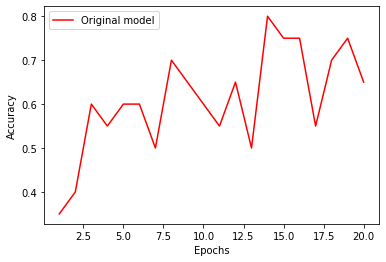

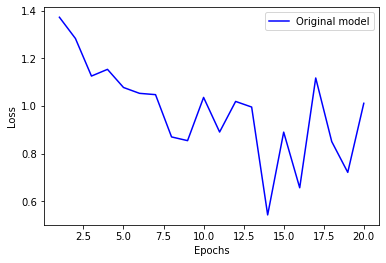

In [ ]:
hist_dict = history.history

val_acc = hist_dict['val_acc']
val_loss = hist_dict['val_loss']

epochs = range(1, len(val_acc)+1)

plt.plot(epochs, val_acc, 'r', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, val_loss, 'b', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## test 데이터 분류

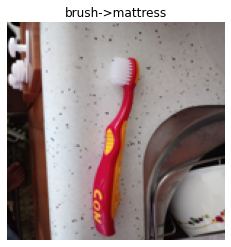

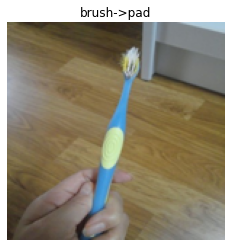

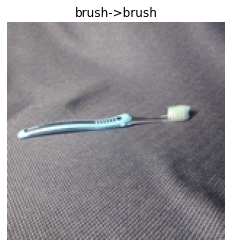

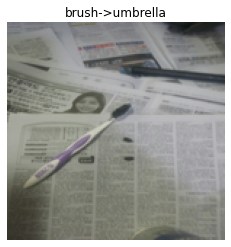

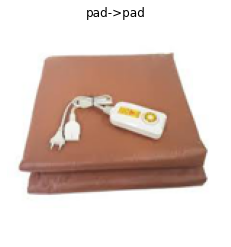

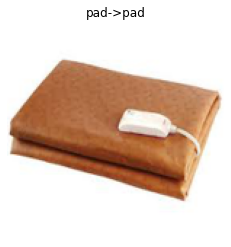

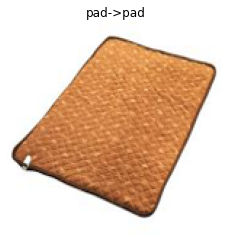

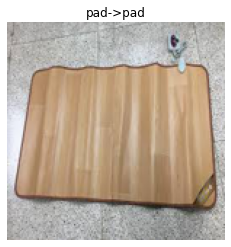

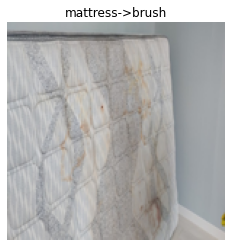

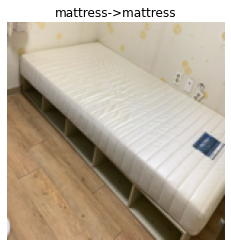

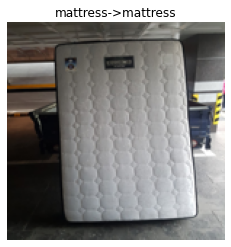

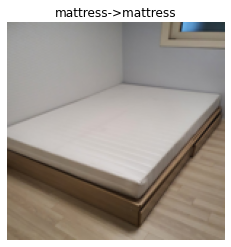

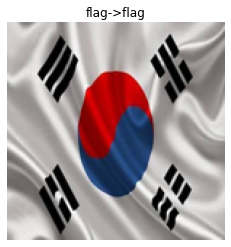

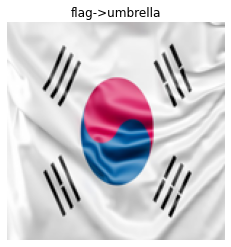

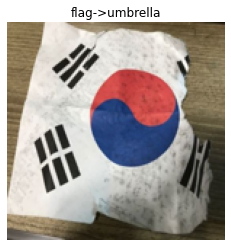

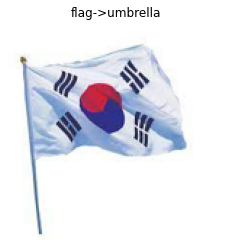

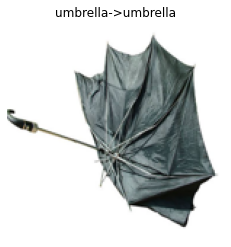

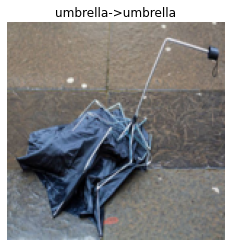

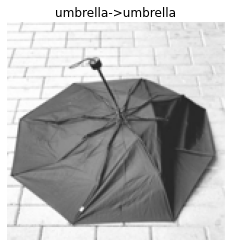

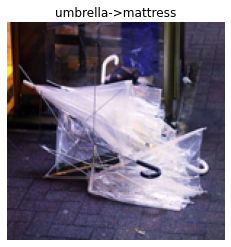

OSError: ignored

In [ ]:
from PIL import Image

folders = os.listdir(test_dir) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음

for i in range(len(folders)):
  path = test_dir + "/" + folders[i] 
  os.chdir(path) # 해당 폴더로 이동
  files = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
  for j in range(len(files)):
    test_image = path + '/' + files[j]
    img = Image.open(test_image)
    img = img.convert("RGB")
    img = img.resize((150,150))
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, 150, 150,3)

    # 예측
    pred = model.predict(X)  
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    categories = ["brush", "flag", "mattress", "pad", "umbrella"]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(label=folders[i]+'->'+categories[result[0]], loc='center')
    plt.show()

In [41]:
import pandas as pd

df = pd.read_csv("/content/gdrive/MyDrive/분리배출방법.csv")
df

,제품영문,제품한글,배출방법
0,bag,가방,일반 쓰레기
1,battery,건전지,아파트 또는 주민센터 폐건전지 수거함에 버리기
2,bed,침대 틀,일반 쓰레기
3,blanket,담요,일반 쓰레기
4,brush,칫솔,일반 쓰레기
5,computer,컴퓨터,"하드디스크 분리, 폐기, 포맷 후 고물상에 처분 / 중고거래 / 폐기물 스티커 부착..."
6,cosmetic,화장품,"내용물은 휴지, 신문지, 두꺼운 종이 같은데 싸거나 흡수시켜서 일반쓰레기로 배출하기..."
7,dish,접시,일반 쓰레기
8,doll,인형,일반 쓰레기
9,dryer,건조대,폐기물 스티커 부착해서 버리기


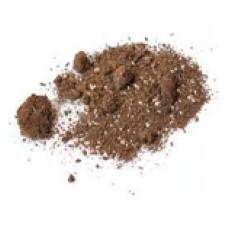

모래 을(를) 버리시는군요!
배출방법은 비닐봉투에 밀봉 후 특수규격 봉투(종량제 마대)에 배출하기


In [49]:
def test(test_image):   
    img = Image.open(test_image)
    img = img.convert("RGB")
    img = img.resize((150,150))
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, 150, 150,3)

    # 예측
    pred = model.predict(X)  
    result = [np.argmax(value) for value in pred]
    category = df['제품한글'][result[0]-1]
    solution = df['배출방법'][result[0]-1]

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print( category + " 을(를) 버리시는군요!\n" + "배출방법은 " + solution) 


test("/content/gdrive/MyDrive/dataa/test/sand/images (12).jpeg")    

In [68]:
from sklearn.metrics import confusion_matrix,classification_report

predict = model.predict(test_generator)
result = [np.argmax(value) for value in predict]

print(classification_report(test_generator.classes, result))

              precision    recall  f1-score   support

           0       0.02      0.10      0.03        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.02      0.05      0.03        20
           4       0.00      0.00      0.00        20
           5       0.03      0.25      0.05        20
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00        20
           9       0.00      0.00      0.00        20
          10       0.00      0.00      0.00        20
          11       0.11      0.05      0.07        20
          12       0.00      0.00      0.00        20
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00        20
          15       0.07      0.30      0.11        20
          16       0.00      0.00      0.00        20
          17       0.09    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
import matplotlib as mpl
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test_generator.classes, result) #곡선 그리기

plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, color='y')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

score = metrics.auc(fpr, tpr) #면적 구하기
print(score) #1.0

plt.title('ROC (Receiver Operating Characteristic) Curve (AUC = {})'.format(round(score,4)))
plt.show()

ValueError: ignored